# Initial Tests
Thomas Schanzer z5310829  
School of Physics, UNSW  
September 2021

In this notebook, we explore the capabilities of the MetPy package and
test some of its functions on the basic example of an air parcel rising
from ground level. We will vary the initial temperature and specific
humidity of the parcel and investigate the effect on the parcel's
temperature and specific humidity as it rises.

## Table of Contents
- [Basic Plots](#Ascent:-basic-plots)
- [Specfic humidity vs. pressure and intial specfic humidity for constant initial temperature](#Ascent:-specfic-humidity-vs.-pressure-and-intial-specfic-humidity-for-constant-initial-temperature)
- [Specfic humidity vs. pressure and intial temperature for constant initial specific humidity](#Ascent:-specfic-humidity-vs.-pressure-and-intial-temperature-for-constant-initial-specific-humidity)
- [LCL vs. initial temperature and specific humidity](#LCL-vs.-initial-temperature-and-specific-humidity)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.units import units
from metpy.units import concatenate
from metpy.plots import SkewT
from os import mkdir
from os.path import exists

In [5]:
fig_path = ('/Users/tschanzer/OneDrive - UNSW/UNSW2021/T3/ToR/'
            'taste-of-research-21T3/analysis/20210901_initial_tests_figures/')
if not exists(fig_path):
    mkdir(fig_path)

## Ascent: basic plots

We first define some new functions that combine various MetPy functions
to better suit our example.

In [6]:
# MetPy calculates parcel profiles using an initial dew point so we
# must convert the initial specific humidity we would like to use into
# a dew point.
def parcel_profile_from_q(pressure, initial_temperature, initial_q):
    """
    Calculates parcel profile given initial temperature and specific humidity.
    
    Args:
        pressure: Pressure levels at which to calculate the profile.
        initial_temperature: Temperature of the parcel at pressure[0].
        initial_q: Specific humidity of the parcel at pressure[0].
        
    Returns:
        The temperature of the parcel at the levels given.
    """
    
    initial_dewpoint = mpcalc.dewpoint_from_specific_humidity(
        pressure[0], initial_temperature, initial_q)
    return mpcalc.parcel_profile(
        pressure, initial_temperature, initial_dewpoint)

# MetPy calculates equivalent potential temperature using dew point
# as well, so we would like to find the parcel's dew point as a function
# of pressure as it rises.
# We must address the complication that the specific humidity stays
# constant at the initial value until the parcel reaches the LCL,
# above which water will condense and precipitate out.
def dewpoint_from_profile(pressure, temperature, initial_q):
    """
    Calculates the dewpoint of a parcel.
    
    Args:
        pressure: Pressure levels.
        temperature: Temperature of the parcel at each point in
            pressure.
        initial_q: Specific humidity of the parcel at pressure[0].
        
    Returns:
        The dewpoint of the parcel at the levels given.
    """
    
    initial_dewpoint = mpcalc.dewpoint_from_specific_humidity(
        pressure[0], temperature[0], initial_q)
    lcl, _ = mpcalc.lcl(pressure[0], temperature[0], initial_dewpoint)
    dewpoint = concatenate([
        # calculate dewpoint for levels below LCL
        mpcalc.dewpoint_from_specific_humidity(
            pressure[pressure > lcl], 
            temperature[pressure > lcl], 
            initial_q),
        # dewpoint = temperature above LCL
        temperature[pressure <= lcl],
    ])
    return dewpoint

# We can now use the previous function to find the equivalent potential
# temperature as a function of pressure.
def thetae_from_profile(pressure, temperature, initial_q):
    """
    Calculates the equivalent potential temperature of a parcel.
    
    Args:
        pressure: Pressure levels.
        temperature: Temperature of the parcel at each point in
            pressure.
        initial_q: Specific humidity of the parcel at pressure[0].
        
    Returns:
        The equivalent potential temperature of the parcel at the levels
            given.
    """
    
    dewpoint = dewpoint_from_profile(pressure, temperature, initial_q)
    return mpcalc.equivalent_potential_temperature(
        pressure, temperature, dewpoint)

# We would also like to find the parcel's specific humidity as a
# function of pressure.
def q_from_profile(pressure, temperature, initial_q):
    """
    Calculates the specific humidity of a parcel.
    
    Args:
        Args:
        pressure: Pressure levels.
        temperature: Temperature of the parcel at each point in
            pressure.
        initial_q: Specific humidity of the parcel at pressure[0].
        
    Returns:
        The specific humidity of the parcel at the levels given.
    """
    
    dewpoint = dewpoint_from_profile(pressure, temperature, initial_q)
    return mpcalc.specific_humidity_from_dewpoint(pressure, dewpoint)

We now perform an example calculation and plot the parcel's temperature
profile on a skew $T$ - $\log p$ plot.

In [7]:
# pressure levels
pressure = np.linspace(1000, 200, 50) * units.mbar
t0 = 20*units.celsius

# dry ascent
temp_dry = mpcalc.dry_lapse(pressure, t0)
theta_dry = mpcalc.potential_temperature(pressure, temp_dry)

# saturated ascent (temperature = dewpoint)
temp_sat = mpcalc.moist_lapse(pressure, t0)
thetae_sat = mpcalc.equivalent_potential_temperature(
    pressure, temp_sat, temp_sat)
q_sat = mpcalc.specific_humidity_from_dewpoint(pressure, temp_sat)

# sub-saturated ascent
q0 = 4e-3
temp_subsat = parcel_profile_from_q(pressure, t0, q0)
thetae_subsat = thetae_from_profile(pressure, temp_subsat, q0)
q_subsat = q_from_profile(pressure, temp_subsat, q0)

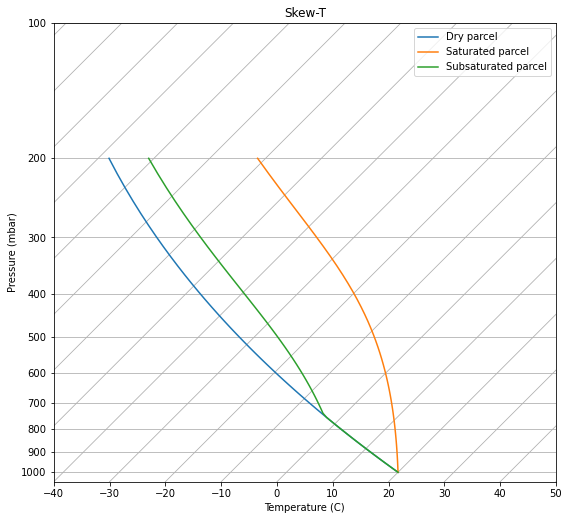

In [8]:
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig, subplot=(1,1,1), rotation=45)
skew.plot(pressure, temp_dry, label='Dry parcel')
skew.plot(pressure, temp_sat, label='Saturated parcel')
skew.plot(pressure, temp_subsat, label='Subsaturated parcel')
# skew.plot_mixing_lines()
skew.ax.legend()
skew.ax.set(title='Skew-T', xlabel='Temperature (C)', ylabel='Pressure (mbar)')
plt.show()

We can see that the potential temperature of the dry parcel, and the
equivalent potential temperatures of the subsaturated and saturated
parcels, are conserved.

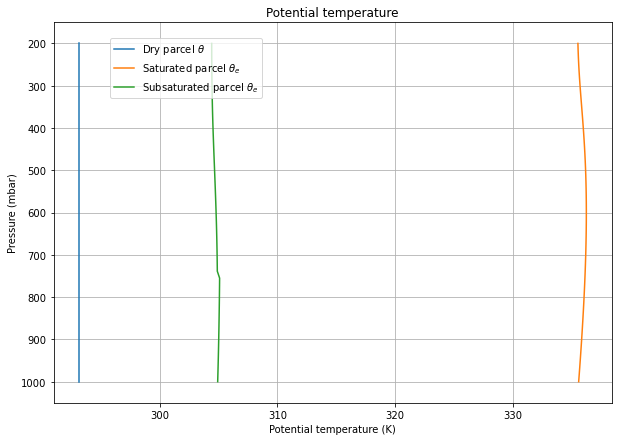

In [9]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.plot(theta_dry, pressure, label=r'Dry parcel $\theta$')
ax.plot(thetae_sat, pressure, label=r'Saturated parcel $\theta_e$')
ax.plot(thetae_subsat, pressure, label=r'Subsaturated parcel $\theta_e$')
ax.legend(loc=(0.1,0.8))
ax.grid()
ax.set_ylim(1050, 150)
ax.set(
    title='Potential temperature',
    xlabel='Potential temperature (K)',
    ylabel='Pressure (mbar)')
plt.show()

We can also see the specific humidity of the parcel decreasing with
height above the LCL.

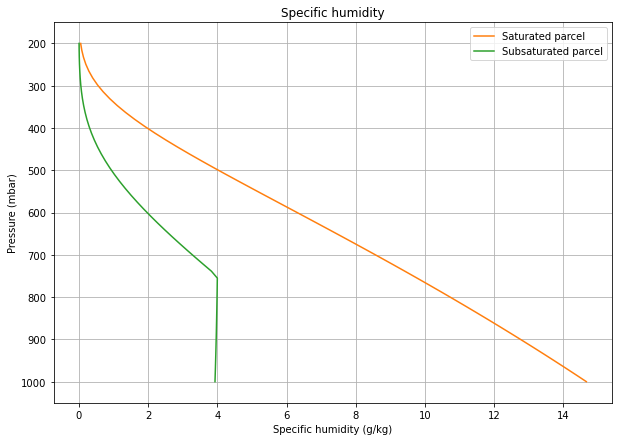

In [10]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.plot(q_sat*1e3, pressure, label='Saturated parcel', color='tab:orange')
ax.plot(q_subsat*1e3, pressure, label='Subsaturated parcel', color='tab:green')
ax.legend()
ax.grid()
ax.set_ylim(1050, 150)
ax.set(
    title='Specific humidity',
    xlabel='Specific humidity (g/kg)',
    ylabel='Pressure (mbar)'
)
plt.show()

## Ascent: specfic humidity vs. pressure and intial specfic humidity for constant initial temperature

We now seek to show how the specific humidity of the parcel changes with
pressure for a range of initial specific humidities, fixing the initial
temperature.

We first define some helper functions.

In [11]:
# MetPy's parcel_profile function only works on 1D arrays, so we
# must extend it to 2D arrays.
def parcel_profile_from_q_range(
        pressure, initial_temperature_range, initial_q_range):
    """
    Calculates parcel profiles for a set of pairs of initial q and T.
    
    Args:
        pressure: Pressure levels at which to calculate the profile.
        initial_temperature_range: Initial temperatures.
        initial_q_range: Initial specific humidities.
        
    Returns:
        An array of parcel profiles with each row corresponding to
            a different initial specific humidity.
    """
    
    # in case only one profile is being calculated
    initial_temperature_range = np.atleast_1d(initial_temperature_range)
    initial_q_range = np.atleast_1d(initial_q_range)
    
    initial_dewpoint = concatenate([
        mpcalc.dewpoint_from_specific_humidity(pressure[0], T0, q0)
        for T0, q0 in zip(initial_temperature_range, initial_q_range)
    ])
    profile = concatenate([
        [mpcalc.parcel_profile(pressure, T0, Td)]
        for T0, Td in zip(initial_temperature_range, initial_dewpoint)
    ])*units.kelvin
    return np.squeeze(profile)

# We now calculate the dewpoints and specific humidities for
# the 2D temperature data.
def dewpoint_from_profile_array(pressure, temperature, initial_q_range):
    """
    Calculates the dewpoint of an array of parcel profiles.
    
    Args:
        Args:
        pressure: Pressure levels.
        temperature: Array of parcel temperatures with each row
            corresponding to a different initial specific humidity.
        initial_q_range: Range of initial specific humidities.
        
    Returns:
        The specific humidity of the parcel at the levels given.
    """
    
    # in case only one profile is being calculated
    initial_q_range = np.atleast_1d(initial_q_range)
    temperature = np.atleast_2d(temperature)
    
    initial_dewpoint = mpcalc.dewpoint_from_specific_humidity(
        pressure[0], temperature[:,0], initial_q_range)
    lcl = concatenate([
        mpcalc.lcl(pressure[0], T0, Td)[0]
        for T0, Td in zip(temperature[:,0], initial_dewpoint)
    ])
    
    # take each row (i.e., each profile) and calculate the
    # dewpoint both below and above the LCL, then re-join the
    # dewpoint profiles into an array
    dewpoint = concatenate([[
        concatenate([
            # calculate dewpoint for levels below LCL
            mpcalc.dewpoint_from_specific_humidity(
                pressure[pressure > lcl[i]], 
                temperature[i, pressure > lcl[i]], 
                initial_q_range[i]).to(units.kelvin),
            # dewpoint = temperature above LCL
            temperature[i, pressure <= lcl[i]],
        ]) for i in range(temperature.shape[0])
    ]])*units.kelvin
    return np.squeeze(dewpoint)

def q_from_profile_array(pressure, temperature, initial_q_range):
    """
    Calculates the specific humidity of a parcel.
    
    Args:
        Args:
        pressure: Pressure levels.
        temperature: Temperature of the parcel at each point in
            pressure.
        initial_q: Specific humidity of the parcel at pressure[0].
        
    Returns:
        The specific humidity of the parcel at the levels given.
    """
    
    dewpoint = dewpoint_from_profile_array(
        pressure, temperature, initial_q_range)
    return mpcalc.specific_humidity_from_dewpoint(pressure, dewpoint)

We now proceed with the example, using a colour scale to represent
specific humidity.

In [12]:
pressure = np.linspace(1000, 200, 50) * units.mbar
q0 = np.arange(0.1e-3, 7.5e-3, 0.2e-3)
t0 = np.ones(len(q0))*10*units.celsius

temp_subsat = parcel_profile_from_q_range(pressure, t0, q0)
q_subsat = q_from_profile_array(pressure, temp_subsat, q0)

# find LCLs for line on plot
initial_dewpoint = mpcalc.dewpoint_from_specific_humidity(
    pressure[0], temp_subsat[:,0], q0)
lcl = concatenate([
    mpcalc.lcl(pressure[0], T0, Td)[0]
    for T0, Td in zip(temp_subsat[:,0], initial_dewpoint)
])

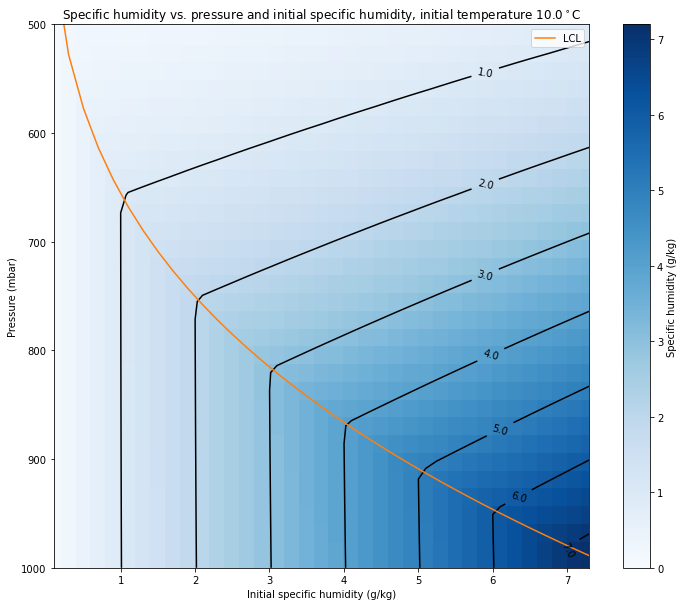

In [13]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)

# q image plot
mesh = ax.pcolormesh(
    q0*1e3, pressure, q_subsat.T*1e3, 
    shading='nearest',
    cmap='Blues',
)
mesh.set_clim(0,7.2)
cbar = plt.colorbar(mesh)
cbar.set_label('Specific humidity (g/kg)')

contour = ax.contour(
    q0*1e3, pressure, q_subsat.T*1e3,
    levels=np.arange(1, 8, 1),
    colors='k',
)
ax.clabel(contour, fmt='%1.1f')

# LCL line
ax.plot(q0*1e3, lcl, color='tab:orange', label='LCL')

ax.set_ylim(1000, 500)
ax.legend()
ax.set(
    title=r'Specific humidity vs. pressure and initial specific '
        'humidity, initial temperature '
        '{0:.1f}$^\circ$C'.format(t0[0].magnitude),
    xlabel='Initial specific humidity (g/kg)',
    ylabel='Pressure (mbar)',
)
plt.show()

# fig.savefig(
#     fig_path + 'q_vs_p_and_q0.png', dpi=300, facecolor='w',
#     bbox_inches='tight')

We can see that the specific humidity is constant below the LCL and decreases
above it towards the limiting value of 0, and that the height of the LCL
decreases as the initial specific humidity increases.

## Ascent: specfic humidity vs. pressure and intial temperature for constant initial specific humidity

We now repeat the previous example, this time varying the initial
temperature and fixing the initial specific humidity.

In [14]:
pressure = np.linspace(1000, 200, 50) * units.mbar
t0 = np.arange(2, 31, 1)*units.celsius
q0 = np.ones(len(t0))*4e-3

temp_subsat = parcel_profile_from_q_range(pressure, t0, q0)
q_subsat = q_from_profile_array(pressure, temp_subsat, q0)

# find LCLs for line on plot
initial_dewpoint = mpcalc.dewpoint_from_specific_humidity(
    pressure[0], temp_subsat[:,0], q0)
lcl = concatenate([
    mpcalc.lcl(pressure[0], T0, Td)[0]
    for T0, Td in zip(temp_subsat[:,0], initial_dewpoint)
])

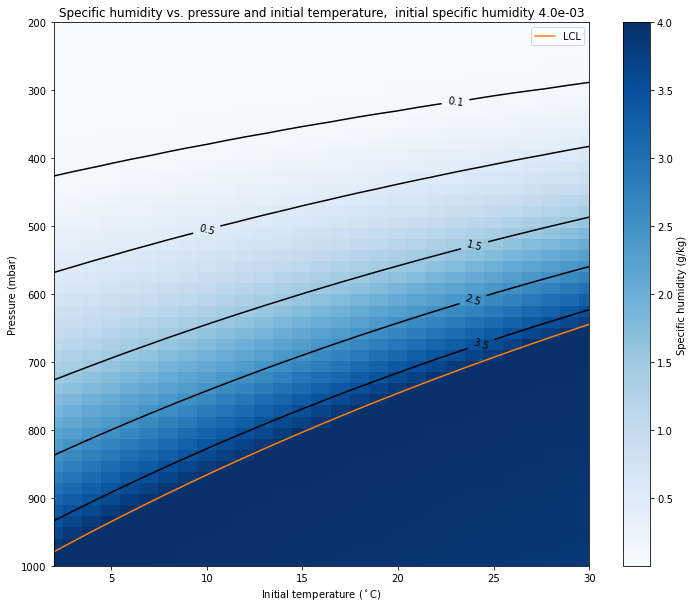

In [15]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)

# q image plot
mesh = ax.pcolormesh(
    t0, pressure, q_subsat.T*1e3, 
    shading='nearest',
    cmap='Blues',
)
# mesh.set_clim(0,7.2)
cbar = plt.colorbar(mesh)
cbar.set_label('Specific humidity (g/kg)')

contour = ax.contour(
    t0, pressure, q_subsat.T*1e3,
    levels=np.concatenate([[0.1], np.arange(0.5, 4.1, 1)]),
    colors='k',
)
ax.clabel(contour, fmt='%1.1f')

# LCL line
ax.plot(t0, lcl, color='tab:orange', label='LCL')

ax.set_ylim(1000, 200)
ax.legend()
ax.set(
    title=r'Specific humidity vs. pressure and initial temperature, '
        ' initial specific humidity {0:.1e}'.format(q0[0]),
    xlabel=r'Initial temperature ($^\circ$C)',
    ylabel='Pressure (mbar)',
)
plt.show()

# fig.savefig(
#     fig_path + 'q_vs_p_and_T0.png', dpi=300, facecolor='w',
#     bbox_inches='tight')

Again, we can see that the specific humidity decays above the LCL.
We can also see that the height of the LCL increases with initial
temperature.

## LCL vs. initial temperature and specific humidity

We will briefly show how the LCL depends on the initial temperature
and specific humidity of the parcel.

In [16]:
T0 = np.arange(-30, 31, 1)
q0 = np.arange(0.1e-3, 10e-3, 0.25e-3)
T, Q = np.meshgrid(T0, q0)
T = T*units.celsius
p0 = 1e3*units.mbar

dewpoint = mpcalc.dewpoint_from_specific_humidity(p0, T, Q)
lcl = np.zeros(T.shape)
for i in range(len(q0)):
    for ii in range(len(T0)):
        lcl[i,ii] = mpcalc.lcl(
            p0, T0[ii]*units.celsius, dewpoint[i, ii])[0].magnitude
lcl = lcl * units.mbar

/Users/tschanzer/anaconda3/lib/python3.8/site-packages/metpy/calc/thermo.py:1042: UserWarning: Relative humidity >120%, ensure proper units.
  warnings.warn('Relative humidity >120%, ensure proper units.')


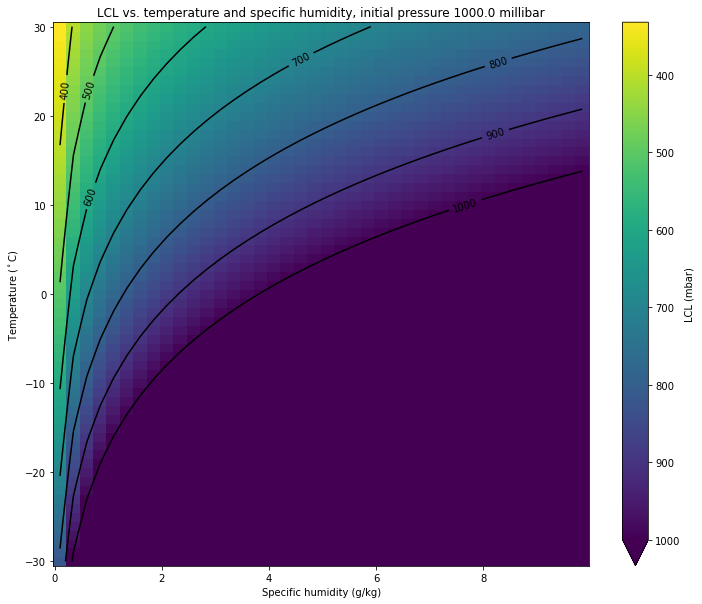

In [17]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)

# q image plot
mesh = ax.pcolormesh(
    q0*1e3, T0, lcl.T, 
    shading='nearest',
    cmap='viridis_r',
)
mesh.set_clim(1000, np.min(lcl).magnitude)
cbar = plt.colorbar(mesh, extend='max')
cbar.set_label('LCL (mbar)')
cbar.ax.invert_yaxis()

contour = ax.contour(
    q0*1e3, T0, lcl.T,
    levels=np.arange(400, 1001, 100),
    colors='k'
)
ax.clabel(contour, fmt='%1.0f')

ax.set(
    title=r'LCL vs. temperature and specific humidity, '
        'initial pressure {0:.1f}'.format(p0),
    xlabel='Specific humidity (g/kg)',
    ylabel=r'Temperature ($^\circ$C)',
)
plt.show()

# fig.savefig(
#     fig_path + 'LCL_vs_T0_and_q0.png', dpi=300, facecolor='w',
#     bbox_inches='tight')